In [89]:
#Todos os imports necessários para aplicação.#
import os
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext
import matplotlib
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, col, udf
from pyspark.sql.types import DateType
import pandas as pd

import re
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path

%matplotlib inline

In [2]:
#Seta variaveis do Data Lake
LANDED = 'C:/Users/970775/Documents/ProjectsPhyton/Bigdata/Projeto/landed/'
RAW = 'C:/Users/970775/Documents/ProjectsPhyton/Bigdata/Projeto/raw/'
MODELED = 'C:/Users/970775/Documents/ProjectsPhyton/Bigdata/Projeto/modeled/'

In [3]:
builder = SparkSession.builder.appName("Insight")
builder.config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2")
builder.config("spark.speculation", "false")
builder.config("spark.sql.parquet.compression.codec", "gzip")

spark = builder.getOrCreate()
sql = SQLContext(spark.sparkContext)

In [4]:
# to read parquet file
parquet_file = sql.read.parquet(MODELED + 'infracao.parquet.gzip')
parquet_file.createOrReplaceTempView("parquettable")

In [6]:
print(" No periodo de 3 anos forma resgistradas {} ".format(parquet_file.count()) + "infracoes de transito")
parquet_file.printSchema()
parquet_file.select(["infracao","localcometimento","agenteequipamento","datainfracao"]).describe().show()
parquet_file.select("localcometimento").distinct().show(n = 15)
x = parquet_file.groupby("datainfracao").count()
parquet_file.groupby("datainfracao").count().show(n = 5)

 No periodo de 3 anos forma resgistradas 1650919 infracoes de transito
root
 |-- datainfracao: string (nullable = true)
 |-- horainfracao: string (nullable = true)
 |-- infracao: string (nullable = true)
 |-- localcometimento: string (nullable = true)
 |-- agenteequipamento: string (nullable = true)
 |-- descricaoinfracao: string (nullable = true)

+-------+-----------------+--------------------+--------------------+------------+
|summary|         infracao|    localcometimento|   agenteequipamento|datainfracao|
+-------+-----------------+--------------------+--------------------+------------+
|  count|          1650919|             1650919|             1650919|     1650919|
|   mean|6589.961039228501|                null|   6.884773290283074|        null|
| stddev|926.6981648390008|                null|   420.2615435921201|        null|
|    min|             5010|,rua minas gerais...|              225310|  2017-01-01|
|    max|         infracao|visconde de albuq...|código 9 - faixa ...

In [72]:
#Prepara as informações via SQL
Q20 = spark.sql("select substr(datainfracao,1,4) as Ano, substr(datainfracao,6,2) as Mes, substr(datainfracao,9,2) as dia, count(*) as contador "
               "from parquettable where substr(datainfracao,1,4) in ('2017','2018') "+
               "group by substr(datainfracao,1,4), substr(datainfracao,6,2), substr(datainfracao,9,2) "+
               "order by substr(datainfracao,9,2), substr(datainfracao,6,2), substr(datainfracao,1,4)")

Q21 = spark.sql("select substr(datainfracao,6,2) as Mes, count(*) as contador "
                "from parquettable "+
                "where substr(datainfracao,6,2) <> 'nf' and substr(datainfracao,1,4) in ('2017','2018') "+
                "group by substr(datainfracao,6,2) "+
                "order by substr(datainfracao,6,2)")

Q22 = spark.sql("select substr(datainfracao,1,4) as Ano, count(*) as contador "
                "from parquettable "+
                "where substr(datainfracao,1,4) in ('2017','2018') "+
                "group by substr(datainfracao,1,4) "+
                "order by substr(datainfracao,1,4)")

Q221 = spark.sql("select substr(datainfracao,1,4) as Ano, count(*) as contador "+
                "from parquettable "+
                "where substr(datainfracao,1,4) in ('2017','2018','2019') and substr(datainfracao,6,2) in('01','02','03') "+
                "group by substr(datainfracao,1,4) "+
                "order by substr(datainfracao,1,4)")

Q23 = spark.sql("select substr(horainfracao,1,2) as Hora, count(*) as contador "+
                "from parquettable where substr(datainfracao,1,4) in ('2017','2018') "+
                "group by substr(horainfracao,1,2) "+
                "order by substr(horainfracao,1,2)")

Q231 = spark.sql("select substr(horainfracao,1,2) as Hora, count(*) as contador "
                "from parquettable where substr(datainfracao,1,4) in ('2017','2018','2019') and substr(datainfracao,6,2) in('01','02','03') "+ 
                "group by substr(horainfracao,1,2) "+
                "order by substr(horainfracao,1,2)")

Q24 = spark.sql("select equipamento, sum(contador) as conta from (select case when substr(agenteequipamento,1,8) = 'código 3' or substr(agenteequipamento,1,8) = '3' then 'Lombada Eletronica' "+
                "when substr(agenteequipamento,1,8) = 'código 4' or substr(agenteequipamento,1,8) = '4' then 'Radar' "+
                "when substr(agenteequipamento,1,8) = 'código 5' or substr(agenteequipamento,1,8) = '5' then 'Foto Sensor' "+
                "when substr(agenteequipamento,1,8) = 'código 8' or substr(agenteequipamento,1,8) = '8' then 'Autos no talão eletrônico' "+
                "when substr(agenteequipamento,1,8) = 'código 7' or substr(agenteequipamento,1,8) = '7' then 'Zona Azul' "+
                "when substr(agenteequipamento,1,8) = 'código 9' or substr(agenteequipamento,1,8) = '9' then 'Faixa Azul' "+
                "end as equipamento, count(*) as contador "+
                "from parquettable where substr(datainfracao,1,4) in ('2017','2018')"+
                "group by substr(agenteequipamento,1,8) "+
                "order by substr(agenteequipamento,1,8)) "+
                "where equipamento is not null group by equipamento ")

Q25 = spark.sql("select equipamento, mes, sum(contador) as conta from (select case when substr(agenteequipamento,1,8) = 'código 3' or substr(agenteequipamento,1,8) = '3' then 'Lombada Eletronica' "+
                "when substr(agenteequipamento,1,8) = 'código 4' or substr(agenteequipamento,1,8) = '4' then 'Radar' "+
                "when substr(agenteequipamento,1,8) = 'código 5' or substr(agenteequipamento,1,8) = '5' then 'Foto Sensor' "+
                "when substr(agenteequipamento,1,8) = 'código 8' or substr(agenteequipamento,1,8) = '8' then 'Autos no talão eletrônico' "+
                "when substr(agenteequipamento,1,8) = 'código 7' or substr(agenteequipamento,1,8) = '7' then 'Zona Azul' "+
                "when substr(agenteequipamento,1,8) = 'código 9' or substr(agenteequipamento,1,8) = '9' then 'Faixa Azul' "+
                "end as equipamento, count(*) as contador, "+
                "substr(datainfracao,6,2) as Mes "
                "from parquettable "+
                "where substr(datainfracao,6,2) <> 'nf' and substr(datainfracao,1,4) in ('2017','2018') "+
                "group by substr(agenteequipamento,1,8), substr(datainfracao,6,2) "+
                "order by substr(agenteequipamento,1,8)) "+
                "where equipamento is not null group by mes, equipamento order by mes, equipamento")

Q26 = spark.sql("select local, sum(contador) as conta from (select localcometimento as local, count(*) as contador "+
                "from parquettable group by localcometimento) "+
                "group by local order by conta desc")

print('Collected ...')

Collected ...


In [73]:
#Forma DataFrame para Panda e Monta Pivot caso necessario
DiaxMesxAno = Q20.toPandas() # completo 2017 a 2019
DiaxMesxAno = pd.pivot_table(DiaxMesxAno, values='contador', index=['dia'], columns=['Ano'], aggfunc=np.sum)
print('Loading DiaxMesxAno ...')
Meses = Q21.toPandas() # Anos de 2017 e 2018
print('Loading Meses ...') 
Ano = Q22.toPandas() # anos de 2017 e 2018
print('Loading Ano ...') 
AnoeMes3 = Q221.toPandas() # anos de 2017 a 2019 , até mes 3
print('Loading AnoeMes3 ...') 
Hora = Q23.toPandas() # anos 2017 e 2018
print('Loading Hora ...') 
HoraeMes3 = Q231.toPandas() # anos 2017 a 2019 , até mes 3
print('Loading HoraeMes3 ...') 
Equipamento = Q24.toPandas() # equipamentos 2017 e 2018
print('Loading Equipamento ...') 
Equipamentoxmes = Q25.toPandas() # equipamento e mes 2017 e 2018
Equipamentoxmes = pd.pivot_table(Equipamentoxmes, values='conta', index=['mes'], columns=['equipamento'], aggfunc=np.sum)
print('Loading Equipamentoxmes ...')    
Local = Q26.toPandas()
Local = Local[:10]
print('Loading Local ...')

Loading DiaxMesxAno ...
Loading Meses ...
Loading Ano ...
Loading AnoeMes3 ...
Loading Hora ...
Loading HoraeMes3 ...
Loading Equipamento ...
Loading Equipamentoxmes ...
Loading Local ...


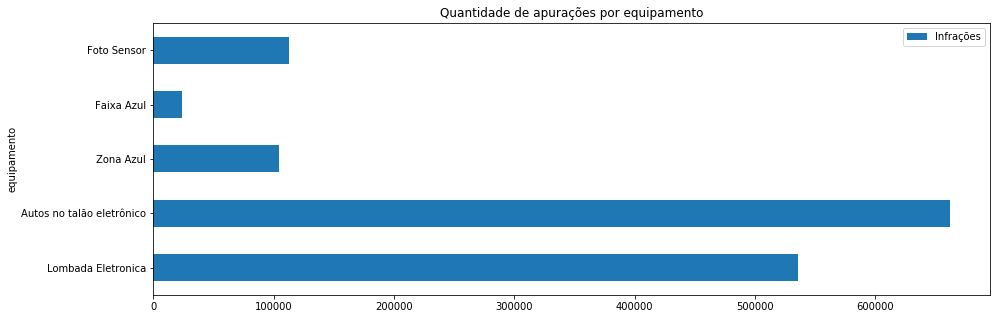

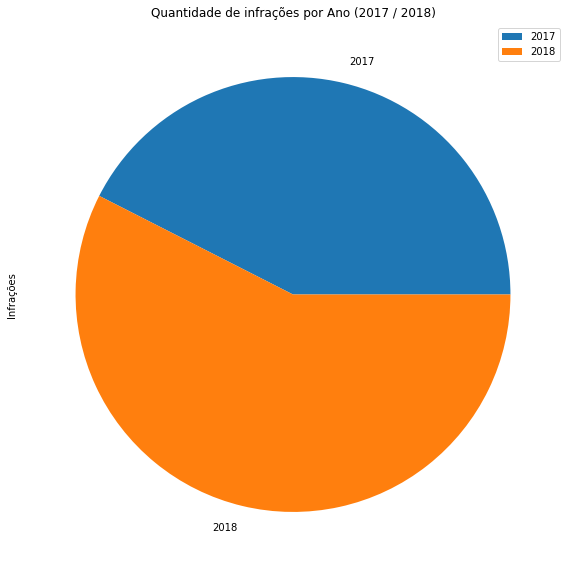

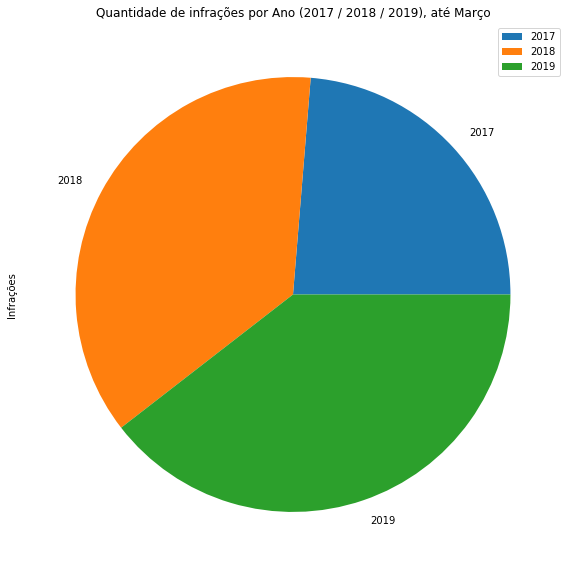

<Figure size 432x288 with 0 Axes>

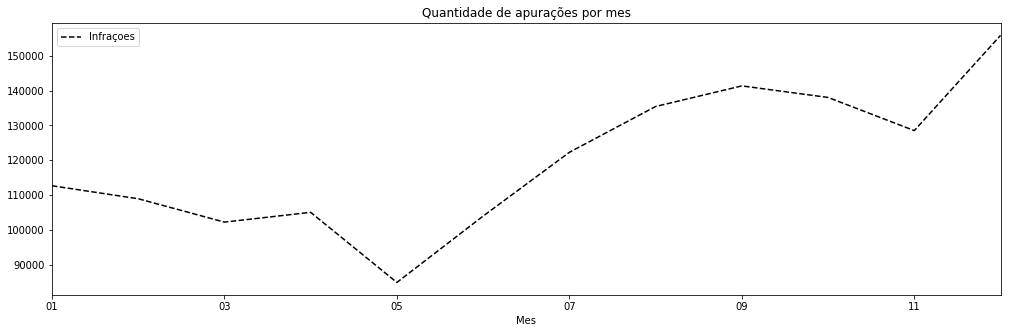

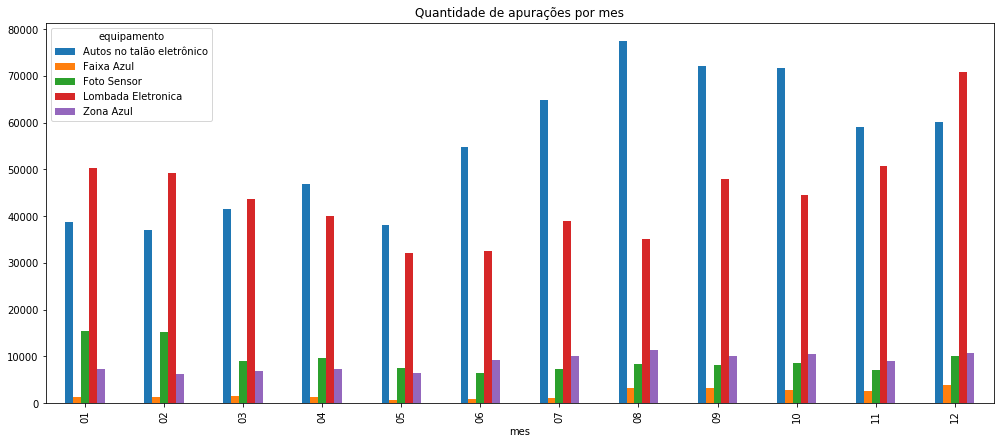

<Figure size 432x288 with 0 Axes>

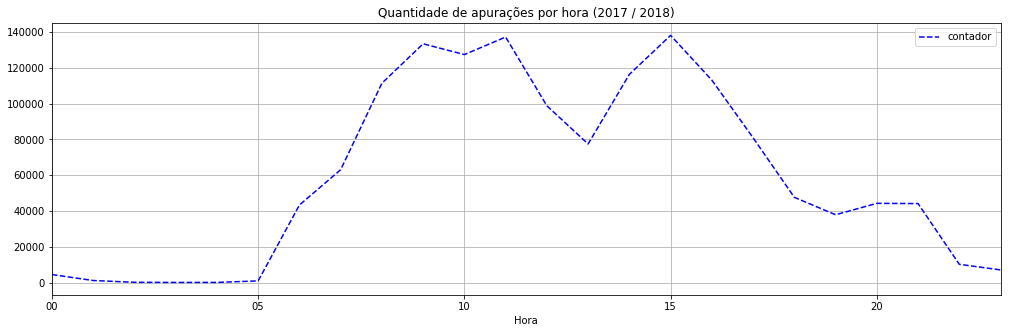

<Figure size 432x288 with 0 Axes>

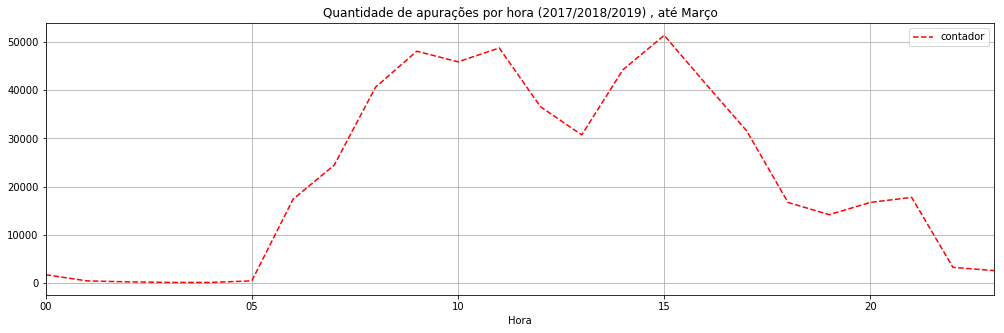

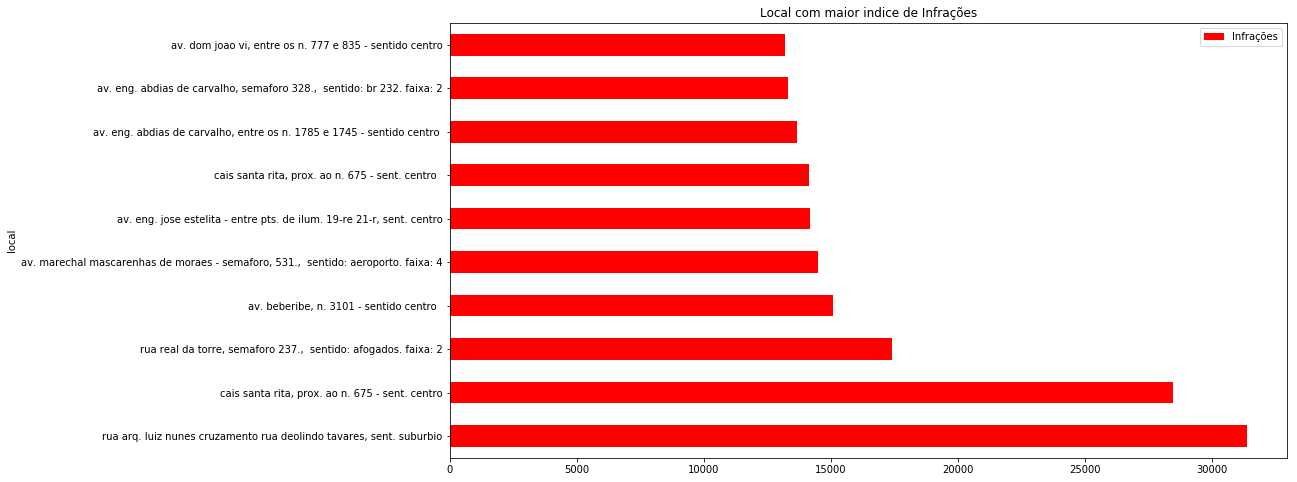

In [88]:
#Graficos
Equipamento.plot(kind = 'barh', x='equipamento', y='conta', 
                 title = 'Quantidade de apurações por equipamento', figsize = (15,5), label = 'Infrações')

Ano.plot(kind = 'pie',  y='contador', x='Ano', 
                 title = 'Quantidade de infrações por Ano (2017 / 2018)', figsize = (12,10) , label = 'Infrações', labels = (r'2017',r'2018'))

AnoeMes3.plot(kind = 'pie',  y='contador', x='Ano', 
                 title = 'Quantidade de infrações por Ano (2017 / 2018 / 2019), até Março', figsize = (12,10) , label = 'Infrações', labels = (r'2017',r'2018',r'2019'))

plt.figure(); Meses.plot(style='k--', x='Mes' , y='contador', 
                         title = 'Quantidade de apurações por mes', figsize = (17,5), label = 'Infraçoes')

Equipamentoxmes.plot(kind = 'bar', title = 'Quantidade de apurações por mes', figsize = (17,7))

plt.figure(); Hora.plot(style='b--', x='Hora', y='contador', 
                         title = 'Quantidade de apurações por hora (2017 / 2018)', figsize = (17,5), grid=True )

plt.figure(); HoraeMes3.plot(style='r--', x='Hora', y='contador', 
                         title = 'Quantidade de apurações por hora (2017/2018/2019) , até Março', figsize = (17,5), grid=True )

Local.plot(kind = 'barh', x='local', y='conta', color = 'red',
                 title = 'Local com maior indice de Infrações', figsize = (15,8), label = 'Infrações')

In [91]:
#Lendo o arquivo
#data
#Definindo a lista de stopwords
Loc = open("C:/Users/970775/Documents/ProjectsPhyton/Bigdata/Projeto/raw/Wordcloud/FD.txt")
locdata = Loc.read()

stopwords = set(STOPWORDS)

#Adicionando a lista stopwords em português
new_words = []
with open("C:/Users/970775/Documents/ProjectsPhyton/Bigdata/Projeto/raw/Wordcloud/stopwords_portuguese.txt", 'r') as f:
    [new_words.append(word) for line in f for word in line.split()]

new_stopwords = stopwords.union(new_words)

Text(0.5, 1.0, 'Locais mais citados')

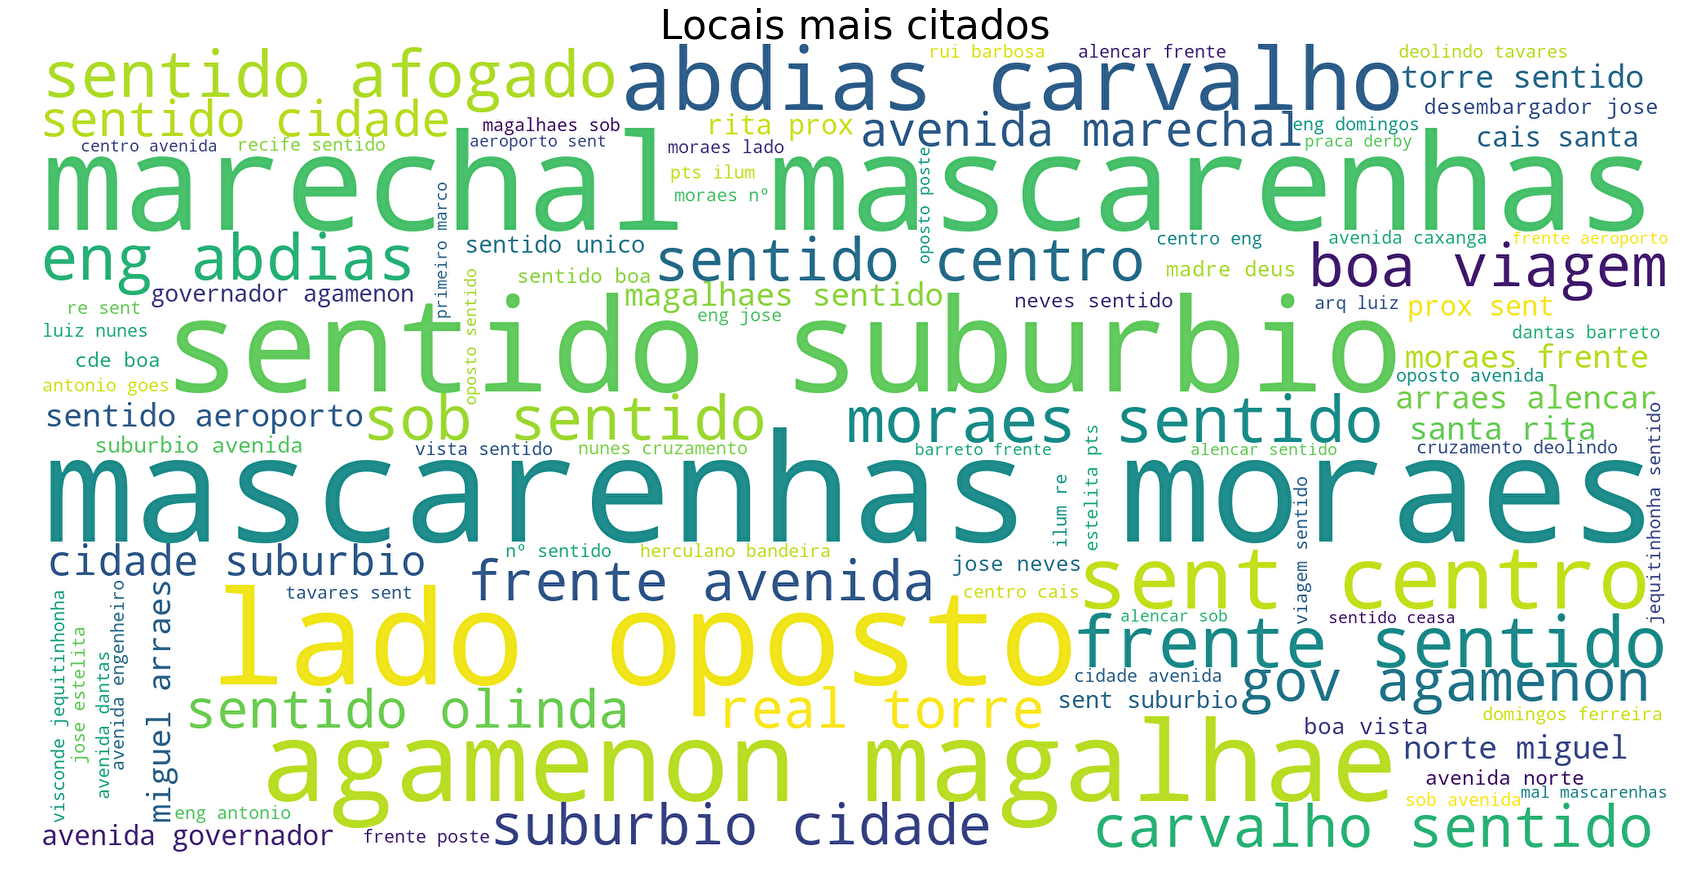

In [98]:
#Printando a wordcloud
plt.figure(figsize=(30,15))
wc = WordCloud(min_font_size=20, 
               max_font_size=200, 
               max_words = 100,
               background_color='white', 
               mode="RGB",
               stopwords=new_stopwords,
               width=2000, 
               height=1000,
               normalize_plurals= True).generate(locdata)


plt.imshow(wc, interpolation="sinc")
plt.axis("off")
plt.title("Locais mais citados", fontsize=40, color="black")